In [45]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
%matplotlib inline

The amount of information is going to be less as the position in the hierarchy increases. And the amount of trust could be random throughout the network.

1 2
possible subordinates [1, 2]
after popping []
##current supervisor 0
####current subordinate 1
i 1
####current subordinate 2
i 1
2 4
possible subordinates [3, 4, 5, 6]
after popping [2]
##current supervisor 1
####current subordinate 3
i 2
####current subordinate 4
i 2
after popping []
##current supervisor 2
####current subordinate 5
i 2
####current subordinate 6
i 2
3 8
possible subordinates [7, 8, 9, 10, 11, 12, 13, 14]
after popping [4, 5, 6]
##current supervisor 3
####current subordinate 7
i 3
####current subordinate 8
i 3
after popping [5, 6]
##current supervisor 4
####current subordinate 9
i 3
####current subordinate 10
i 3
after popping [6]
##current supervisor 5
####current subordinate 11
i 3
####current subordinate 12
i 3
after popping []
##current supervisor 6
####current subordinate 13
i 3
####current subordinate 14
i 3
4 16
possible subordinates [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
after popping [8, 9, 10, 11, 12, 13, 14]
##current supervisor 

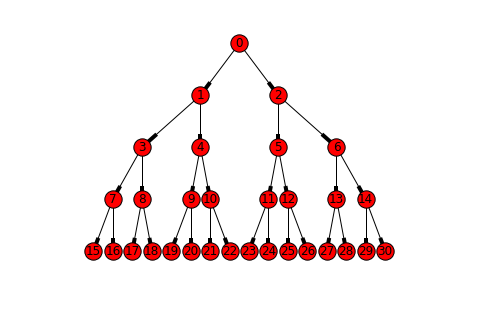

In [2]:
num_levels = 5
num_subordinates = 2
G = nx.DiGraph()
G.add_node(0)
i = 1
leaf_nodes_last_level = [0]
nodes_in_levels = defaultdict(list)
nodes_in_levels[0] = [0]
levels_of_nodes = dict()
levels_of_nodes[0] = 0

for i in range(1, num_levels):
    print i, pow(2,i)
    num_nodes_this_level = pow(2,i)
    possible_subordinates = range(G.number_of_nodes(), G.number_of_nodes()+ num_nodes_this_level )
    leaf_nodes_next_level = list(possible_subordinates)
    print "possible subordinates", possible_subordinates

    while len(leaf_nodes_last_level) > 0:
        current_supervisor = leaf_nodes_last_level.pop(0)
        print "after popping", leaf_nodes_last_level
        print "##current supervisor", current_supervisor
        for j in range(num_subordinates):
            current_subordinate = possible_subordinates.pop(0)
            print "####current subordinate", current_subordinate
            G.add_edge(current_supervisor, current_subordinate)
            print "i", i
            nodes_in_levels[i].append(current_subordinate)
            levels_of_nodes[current_subordinate] = i
    leaf_nodes_last_level = list(leaf_nodes_next_level)
        
# pos = hierarchy_pos(btree2, 0)
#nx.draw(btree2,pos=nx.draw_networkx(btree2),with_labels=True,arrows=True)
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw(G,pos,with_labels=True,arrows=True)

print leaf_nodes_last_level
print leaf_nodes_next_level

Our first assumption is that the deeper the level the less the initial information $H$ in the node. And we will distribute the initial $\alpha$ value distributed randomly using a lognormal distributions with parameter $\mu$ and $\sigma$

In [5]:
levels_of_nodes

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 3,
 8: 3,
 9: 3,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 14: 3,
 15: 4,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 4,
 21: 4,
 22: 4,
 23: 4,
 24: 4,
 25: 4,
 26: 4,
 27: 4,
 28: 4,
 29: 4,
 30: 4}

In [49]:
def sample_h(level):
    dmu = 0.1
    mu = 0.7 - (dmu * (level-1))
    sigma = 0.05
    s = abs(np.random.normal(mu, sigma, 1))[0]
    while s > 1:
        s = abs(np.random.normal(mu, sigma, 1))[0]
    return s

def sample_alpha(mu, sigma):
    s = abs(np.random.normal(mu, sigma, 1))[0]
    #print s
    while s > 1:
        s = abs(np.random.normal(mu, sigma, 1))[0]
    return s

We do not have any problem assigning H in node 0 as there is no edge pointing towards him. So for mu, dmu * (level -1 ) is not a problem.

In [50]:
mean_trust = 0.5
sd_trust = 0.2
for edge in G.edges():
    subordinate_node = edge[1]
    current_h = sample_h(levels_of_nodes[subordinate_node])
    current_alpha = sample_alpha(mean_trust, sd_trust)
    G[edge[0]][edge[1]]['H'] = current_h
    G[edge[0]][edge[1]]['alpha'] = current_alpha
    

In [51]:
not 1

False

In [52]:
order = 0
root_node = 0
bits = dict()
bits[root_node] = order

for edge in list(nx.bfs_edges(G ,root_node)):
    source_node = edge[0]
    target_node = edge[1]
    source_bit = bits[source_node]
    print edge, source_bit
    processed_info = G[edge[0]][edge[1]]['alpha'] + G[edge[0]][edge[1]]['H'] * source_bit
    print "## processed_info", processed_info
    if processed_info > 1:
        print "## first if"
        processed_bit = source_bit
    else: 
        print "## else"
        processed_bit = 1 - source_bit
    bits[target_node] = processed_bit
    #print edge, processed_info,processed_bit

(0, 1) 0
## processed_info 0.955032577741
## else
(0, 2) 0
## processed_info 0.565895590856
## else
(1, 3) 1
## processed_info 1.17233728555
## first if
(1, 4) 1
## processed_info 1.1837232521
## first if
(2, 5) 1
## processed_info 0.805040860623
## else
(2, 6) 1
## processed_info 1.25556642898
## first if
(3, 8) 1
## processed_info 1.0465655273
## first if
(3, 7) 1
## processed_info 1.05167217182
## first if
(4, 9) 1
## processed_info 0.731199123054
## else
(4, 10) 1
## processed_info 1.13831276547
## first if
(5, 11) 0
## processed_info 0.55183044917
## else
(5, 12) 0
## processed_info 0.655534291299
## else
(6, 13) 1
## processed_info 1.19426442932
## first if
(6, 14) 1
## processed_info 0.861500926503
## else
(8, 17) 1
## processed_info 1.08530949774
## first if
(8, 18) 1
## processed_info 1.02065872486
## first if
(7, 16) 1
## processed_info 0.705815414089
## else
(7, 15) 1
## processed_info 1.15648228179
## first if
(9, 19) 0
## processed_info 0.231061265921
## else
(9, 20) 0
## 

In [57]:
print bits

{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0, 15: 1, 16: 0, 17: 1, 18: 1, 19: 1, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1}
